In [115]:
import tensorflow as tf
import matplotlib.pyplot as plt 
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from skimage.transform import resize
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from sklearn.preprocessing import MinMaxScaler

In [2]:
# data from https://www.kaggle.com/shravankumar9892/image-colorization
# download data an put it in a folder in the root called "data"

imgs_gray = np.load("./data/l/gray_scale.npy").reshape((25000, 224, 224, 1))
ab3 = np.load("./data/ab/ab/ab3.npy")
ab2 = np.load("./data/ab/ab/ab2.npy")
ab1 = np.load("./data/ab/ab/ab1.npy")


In [4]:
imgs_ab = np.concatenate((ab1, ab2, ab3), axis=0)
print(imgs_gray.shape)


# shape = (imgs_gray.shape[0],imgs_gray.shape[1],imgs_gray.shape[2], 3)
# imgs_lab = np.zeros(shape)
# imgs_lab[:, :,:,0] = imgs_gray[:, :, :, 0]
# imgs_lab[:, :,:, 1:] = imgs_ab

# print(imgs_gray.shape)
# print(imgs_ab.shape)
# print(img_lab.shape) 

# print(imgs_ab[7].max())
# print(imgs_ab[0])








(25000, 224, 224, 1)


In [5]:
# imgs_array = []
# for i in range(21000, 25000):
#     img = l_ab_to_RGB(imgs_gray[i], imgs_ab[i])
#     img = 1.0/255 * img
#     imgs_array.append(img)

# imgs_array = np.array(imgs_array)
# concat = np.load("./data/test3.npy")
# imgs_array = np.concatenate((concat, imgs_array), axis=0)
# np.save('./data/test7.npy', imgs_array)

# concat1 = np.load("./data/test3.npy")
# concat2 = np.load("./data/test4.npy")
# imgs_array = np.concatenate((concat1, concat2), axis=0)
# np.save('./data/test8.npy', imgs_array)
# stop 4

In [4]:
# test = 0
# test = np.load("./data/test4.npy")
# print(test.shape)
# print(test[11999])
# print(test[2999].max())
# display(test[0])

In [5]:
# splits the data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(imgs_gray, imgs_ab, test_size=0.2, random_state=42, shuffle=True)
X_train.astype('float')
X_test.astype('float')
Y_train.astype('float')
Y_test.astype('float')
print("X_train " + str(X_train.shape))
print("X_test " + str(X_test.shape))
print("y_train " + str(Y_train.shape))
print("y_test " + str(Y_test.shape))

print(X_train.min())
print(X_train.max())

print(Y_train.min())
print(Y_train.max())



X_train (20000, 224, 224, 1)
X_test (5000, 224, 224, 1)
y_train (20000, 224, 224, 2)
y_test (5000, 224, 224, 2)
0
255
20
226


In [6]:
# loads the inceptionResNetV2 for prediction of large features of the images
import tensorflow.compat.v1 as tf_compact
tf_compact.disable_v2_behavior()
inception = InceptionResNetV2(weights=None, include_top=True)
inception.load_weights("./data/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5")
inception.graph = tf_compact.get_default_graph()

Instructions for updating:
non-resource variables are not supported in the long term


[[[  6]
  [  6]
  [  6]
  ...
  [  7]
  [  6]
  [  7]]

 [[  6]
  [  6]
  [ 17]
  ...
  [ 15]
  [  6]
  [  5]]

 [[  6]
  [ 18]
  [137]
  ...
  [140]
  [  5]
  [  6]]

 ...

 [[  7]
  [  6]
  [ 12]
  ...
  [  9]
  [  6]
  [  6]]

 [[  6]
  [  6]
  [  6]
  ...
  [  6]
  [  6]
  [  6]]

 [[  6]
  [  6]
  [  6]
  ...
  [  6]
  [  6]
  [  6]]]


In [7]:
# making the prediction with inceptionResNet
# them the prediction is embed into the imgs
def embed_inception_prediction(img_unsized):
    # resize the image to fit in the resNet
    img_resized = []
    for i in img_unsized:
        img = resize(i, (299, 299, 3), mode='constant')
        img_resized.append(img)
    img_resized = np.array(img_resized)
    # this prepares the data for the resNet
    img_resized = preprocess_input(img_resized)
    with inception.graph.as_default():
        imgs_embed = inception.predict(img_resized)
    return imgs_embed
    


In [8]:

def l_ab_to_RGB(l, ab):
    shape = (l.shape[0], l.shape[1], 3)
    img = np.zeros(shape)
    img[:, :, 0] = l[:, :, 0]
    img[:,:,1:] = ab
    img_rgb = lab2rgb(img)
    return img_rgb


# training_data_gen = ImageDataGenerator(
#     shear_range=0.2,
#     zoom_range=0.2,
#     rotation_range=20
# )


training_data_gen = ImageDataGenerator()

def image_l_ab_datagen(x_train, y_train, batch_size):
    for x_batch, y_batch in training_data_gen.flow(x_train, y_train, batch_size=batch_size):
        imgs_rgb_normalized = []
        for i in len(x_batch):
            rgb = lab2RGB(x_batch[i], y_batch[i])
            rgb_normalized = 1.0/255 * rgb
            imgs_rgb_normalized.append(rgb_normalized)
        imgs_rgb_normalized = np.array(imgs_rgb_normalized)
        gray_embeding = embed_inception_prediction(x_batch)
        # to embeding here
        imgs_lab_normalized = rgb2lab(imgs_rgb_normalized)
        x_train = imgs_lab_normalized[:, :, :, 0]
        x_train = x_train.reshape(x_train.shape + (1,))
        y_train = imgs_lab_normalized[:, :, :, 1:] / 128
        yield([x_train, gray_embeding], y_train)

def image_l_ab_datagen(x_train, y_train, batch_size):
    for x_batch, y_batch in training_data_gen.flow(x_train, y_train, batch_size=batch_size):
        
        gray_embeding = embed_inception_prediction(x_batch)
        # to embeding here
        imgs_lab_normalized = rgb2lab(imgs_rgb_normalized)
        x_train = imgs_lab_normalized[:, :, :, 0]
        x_train = x_train.reshape(x_train.shape + (1,))
        y_train = imgs_lab_normalized[:, :, :, 1:] / 128
        yield([x_train, gray_embeding], y_train)


                

In [ ]:
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.models import Sequential, Model
from keras.layers.core import RepeatVector, Permute


(183, 275, 3)


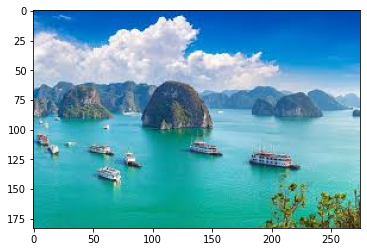

[ 53.95653544  54.65359399  54.19214951  55.7051918   78.09953703
  99.28514535  99.63992896  99.57111066  99.57111066  99.75699005
  99.63992896  99.73334118  98.60204632  99.02882639  99.2358336
  98.12534253  99.80464311  99.78075734  99.90137192  99.97516478
  99.80464311  99.75342383  99.67895806  99.75699005  99.38620891
  98.04968062  99.01513596  98.17745611  99.75699005  99.62991022
  98.68043572  97.54535401  99.50335418  97.19366711  99.07864255
  98.89626328  99.68639853  99.75699005  99.97516478  98.99631341
  98.96399276  98.29923241  98.84082956  98.71090688  99.97516478
 100.          99.11162863  98.07362399  93.48264964  91.39504095
  91.85984885  94.0538141   94.70124386  91.72174083  93.47601488
  95.03025128  92.38445053  92.39335061  92.0739127   92.50123855
  90.74391141  91.76614881  89.02867145  91.92831577  93.88941644
  92.19892741  92.59438425  92.50324298  92.29965956  96.34961882
  92.65809762  98.53275092  95.49761656  86.65345664  80.55664029
  82.754081

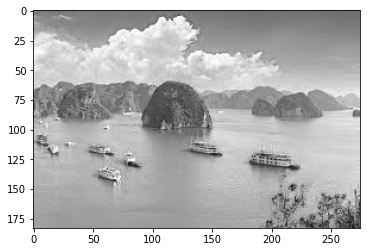

In [110]:

test_img = cv2.imread("./data/testImg.jpeg")
rgb_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
print (rgb_img.shape)

display(rgb_img)
rgb_img.astype("uint8")
img_lab = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2LAB)
img_lab = rgb2lab(test_img)
img_l = img_lab[:, :, 0]
img_ab = img_lab[:, :, 1:]
print(img_l.max())
print(img_l.min())
print(img_ab.max())
print(img_ab.min())
display(img_l)

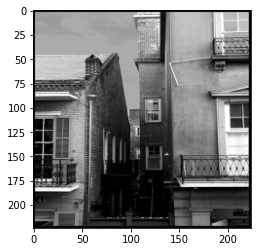

(1, 224, 224, 1)
(1, 224, 224, 3)
(224, 224, 3)


AxisError: axis 2 is out of bounds for array of dimension 2

In [112]:


x_batch = []
y_batch = []

x_batch.append(X_train[3])
y_batch.append(Y_train[3])

x_batch = np.array(x_batch)
y_batch = np.array(y_batch)
display(X_train[0])


batch = 1


def image_l_ab_datagen(x_train, y_train, batch_size):
    for x_batch, y_batch in training_data_gen.flow(x_train, y_train, batch_size=batch_size):
        x_batch = np.array(x_batch)
        y_batch = np.array(y_batch)

        gray_embeding = embed_inception_prediction(x_batch)
        # to embeding here
        
        x_train = (x_batch * (100/255)) / 100
        y_train = y_batch / 128
        yield([x_train, gray_embeding], y_train)

# imgs_rgb_normalized = []
# for i in range(len(x_batch)):
#     rgb_normalized = lab2RGB(x_batch[i], y_batch[i])
#     # rgb = rgb * 255
#     # rgb_normalized = 1.0/255 * rgb_normalized
#     imgs_rgb_normalized.append(rgb_normalized)
# imgs_rgb_normalized = np.array(imgs_rgb_normalized)
# display(imgs_rgb_normalized[0])
# gray_embeding = embed_inception_prediction(x_batch)
# # to embeding here=
# imgs_lab_normalized = rgb2lab(255 *imgs_rgb_normalized)
# x_train = imgs_lab_normalized[:, :, :, 0]
# x_train = x_train.reshape(x_train.shape + (1,))

# y_train = imgs_lab_normalized[:, :, :, 1:]

# y_train[0] =  y_train[0]
# display(x_train[0])
# img_display = lab2RGB(x_train[0], y_train[0])
# display(img_display)

# print(([x_train, gray_embeding], y_train))

print(x_batch.shape)


# embeding predictions
gray_embeding = embed_inception_prediction(x_batch)

imgs_lab = np.zeros((x_batch.shape[0], x_batch.shape[1], x_batch.shape[2], 3))
print(imgs_lab.shape)
imgs_lab[:, :, :, 0] = x_batch[:, :, :, 0]
imgs_lab[:, :, :, 1:] = y_batch

img_lab = imgs_lab[0]
img_lab = img_lab.astype('uint8') 
print(imgs_lab[0].shape)
img_rgb = cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)

imgs_lab_norm = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)

# imgs_l = imgs_lab_norm[:, :, 1:] / 128

imgs_lab_norm_l = imgs_lab_norm[:, :, 0]
imgs_lab_norm_ab = imgs_lab_norm[:, :, 1:]
print(imgs_lab_norm_l.max())
print(imgs_lab_norm_l.min())
print(imgs_lab_norm_ab.max())

print(imgs_lab_norm_ab.min())
# print(imgs_l.max())
# print(imgs_lab)


x_train = (x_batch * (100/255)) / 100

y_train = y_batch / 128
print(y_train.max())
print(y_train.min())
display(x_train[0])
y_train = y_train * 128

x_train = (x_train * 100) * (255/100)

img_to_display = lab2RGB(x_train[0], y_train[0])
display(img_to_display)
# yield([x_train, gray_embeding], y_train)

In [100]:
def get_rbg_from_lab(gray_imgs, ab_imgs, n = 10):
    
    #create an empty array to store images
    imgs = np.zeros((n, 224, 224, 3))
    
    imgs[:, :, :, 0] = gray_imgs[0:n:]
    imgs[:, :, :, 1:] = ab_imgs[0:n:]
    
    #convert all the images to type unit8
    imgs = imgs.astype("uint8")
    
    #create a new empty array
    imgs_ = []
    
    for i in range(0, n):
        imgs_.append(cv2.cvtColor(imgs[i], cv2.COLOR_LAB2RGB))

    #convert the image matrix into a numpy array
    imgs_ = np.array(imgs_)

    #print(imgs_.shape)
    
    return imgs_

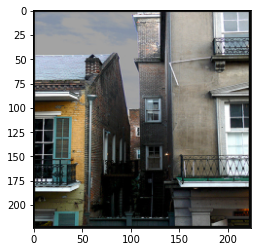

In [9]:
def lab2RGB(l, ab):
    shape = (l.shape[0],l.shape[1],3)
    img = np.zeros(shape)
    img[:,:,0] = l[:,:,0]
    img[:,:,1:] = ab
    img = img.astype('uint8')
    print(img.max())
    img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
    return img
def display(img):
    plt.figure()
    plt.set_cmap('gray')
    plt.imshow(img)
    plt.show()


img = lab2RGB(X_train[0], Y_train[0])
display(img)
    
# testing_resacel = testing_resacel * 255
# testing_res_a_b = testing_res_a_b * 255

# img = l_ab_to_RGB(X_train[1], y_train[1])
# # img = l_ab_to_RGB(testing_resacel, testing_res_a_b)
# # img = np.resize(img, (256, 256, 3))
# img = np.array(resize(img, (300, 300, 3), mode='constant'))
# print(img.shape)

# # testing_resacel = testing_resacel * 255
# # display(testing_resacel)
# display(img)

(189, 267, 3)


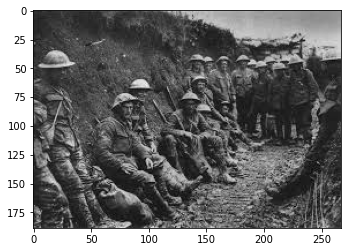

95.49355853071667
0.0
0.004472642101793767
-0.0023595668811604575


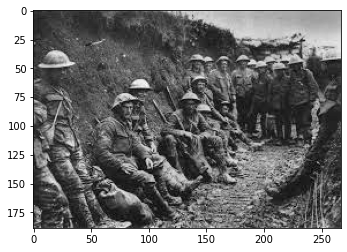

In [118]:
# for loading and image to predict

test_img = cv2.imread("./data/ww1.jpeg")
rgb_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
print (rgb_img.shape)

display(rgb_img)

img_lab = rgb2lab(test_img)
img_l = img_lab[:, :, 0]
img_ab = img_lab[:, :, 1:]
print(img_l.max())
print(img_l.min())
print(img_ab.max())
print(img_ab.min())
display(img_l)